In [ ]:
!pip install ultralytics opencv-python-headless filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
  Cre

In [ ]:
!wget https://raw.githubusercontent.com/abewley/sort/master/sort.py
!sed -i '/matplotlib/d' sort.py  # Remove Matplotlib (not needed in Colab)


--2025-05-07 10:18:17--  https://raw.githubusercontent.com/abewley/sort/master/sort.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11739 (11K) [text/plain]
Saving to: ‘sort.py’

sort.py             100%[===================>]  11.46K  --.-KB/s    in 0s      

2025-05-07 10:18:17 (42.4 MB/s) - ‘sort.py’ saved [11739/11739]



In [ ]:
from ultralytics import YOLO
# Load the updated YOLOv11 model
model = YOLO('yolo11n.pt')  # Replace with yolo11s.pt, yolo11m.pt, etc., for better accuracy


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 76.0MB/s]


In [ ]:
video_path = "/content/car.mp4"  # Update path if needed
output_video_path = "tracked_output.mp4"

from sort import Sort
tracker = Sort()


In [ ]:
import cv2
import numpy as np
import os

# Ensure snapshot directory exists
os.makedirs("wrong_way_snaps", exist_ok=True)

# Re-initialize video
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 640
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 384
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0

output_video_path = "tracked_output.mp4"
out = cv2.VideoWriter(output_video_path,
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps,
                      (frame_width, frame_height))

# Track paths and wrong-way IDs
object_paths = {}
wrong_way_ids = set()
frame_count = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    results = model(frame)[0]
    detections = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(float, box.xyxy[0])
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        if cls in [2, 3, 5, 7]:  # vehicle classes
            detections.append([x1, y1, x2, y2, conf])

    detections_np = np.array(detections) if detections else np.empty((0, 5))
    tracked_objects = tracker.update(detections_np)

    for obj in tracked_objects:
        x1, y1, x2, y2, track_id = map(int, obj)
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        if track_id not in object_paths:
            object_paths[track_id] = []
        object_paths[track_id].append((cx, cy))
        path = object_paths[track_id]

        if len(path) >= 10 and track_id not in wrong_way_ids:
            entry_x = path[0][0]
            exit_x = path[-1][0]
            dx = exit_x - entry_x

            if entry_x < 200 and dx > 50:
                wrong_way_ids.add(track_id)
                msg = f"ID {track_id} - WRONG WAY!"
                cv2.putText(frame, msg, (x1, y2 + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

                # Save snapshot
                snapshot_path = f"wrong_way_snaps/wrong_way_id{track_id}_frame{frame_count}.jpg"
                cv2.imwrite(snapshot_path, frame)

        # Draw tracking box and ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f"ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    out.write(frame)

cap.release()
out.release()
print(" Processing complete. Video saved to:", output_video_path)
print(" Snapshots saved to: wrong_way_snaps/")


Streaming output truncated to the last 5000 lines.

0: 384x640 1 car, 1 truck, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 trucks, 13.6ms
Speed: 3.2ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 13.7ms
Speed: 2.6ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 

📸 Showing 2 wrong-way vehicle snapshots:
🖼️ wrong_way_id201_frame2445.jpg


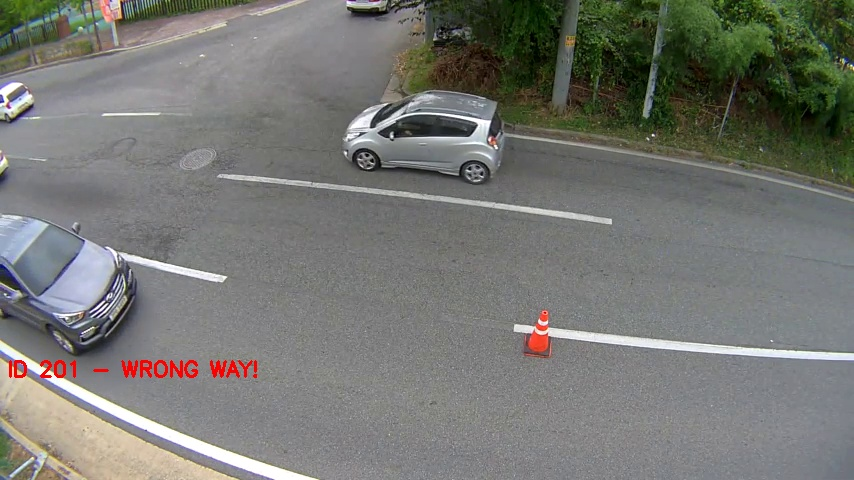

🖼️ wrong_way_id235_frame3155.jpg


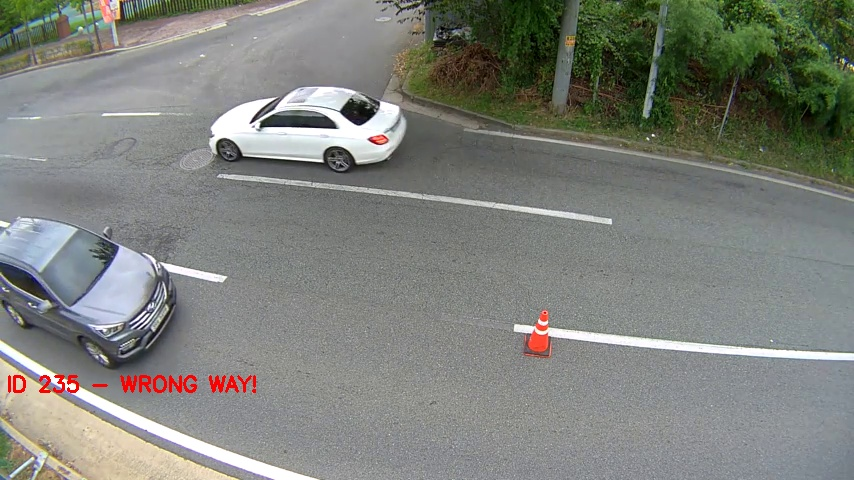

In [ ]:
from IPython.display import Image, display
import glob
import os

# Show all wrong-way vehicle images
snapshots = sorted(glob.glob("wrong_way_snaps/*.jpg"))

if snapshots:
    print(f"📸 Showing {len(snapshots)} wrong-way vehicle snapshots:")
    for snap in snapshots:
        print(f"🖼️ {os.path.basename(snap)}")
        display(Image(snap))
else:
    print("✅ No wrong-way vehicles were detected.")
